<a href="https://colab.research.google.com/github/aatoian/aatoian/blob/main/case_championship_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -r requirements.txt
!pip list | grep -E "langchain|openai|transformers|requests"

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.faiss import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores.utils import DistanceStrategy

In [ ]:
!pip -q install langchain-community==0.4.1
!python -c "import langchain_community; print('langchain_community OK')"


In [ ]:
pip install pypdf

In [ ]:
loader = PyPDFLoader("КР379_4.pdf") #клинические гайдлайны
documents = loader.load()

In [ ]:
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]


text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap=100,
    add_start_index=True,
    strip_whitespace=True,
    separators=MARKDOWN_SEPARATORS,
)


In [ ]:
doc_processed = []
for doc in documents:
    doc_processed += text_splitter.split_documents([doc])

In [ ]:
len(doc_processed)

In [ ]:
import requests
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document

WEB_URLS = [
    "https://pubmed.ncbi.nlm.nih.gov/41213254/",
    "https://bpno.dk/wp-content/uploads/2023/10/ASCO-guidelines-breast-cancer-survivorship-care-1.pdf",
    "https://docslib.org/doc/2272935/nccn-breast-cancer-clinical-practice-guidelines",
    "https://vdoc.pub/documents/esmo-early-breast-cancer-clinical-practice-guidelines-4rvg00h0kj40",
    "https://vdoc.pub/documents/esmo-metastatic-breast-cancer-clinical-practice-guidelines-5r7q1e0k9q80",
    "https://www.nice.org.uk/guidance/ng101/resources/breast-cancer-diagnosis-and-management-pdf-66141532975557",
    "https://www.nice.org.uk/guidance/cg81/resources/advanced-breast-cancer-pdf-975711090885",
    "https://tumourclassification.iarc.who.int/chapters/32",
    "https://cr.minzdrav.gov.ru/view-cr/379_4",
    "https://nop2030.ru/dokumenty/klinicheskie-rekomendatsii-rak-molochnoj-zhelezy/",
    "https://disuria.ru/_ld/12/1279_kr21D05C50MZ.pdf",
    "https://rosoncoweb.ru/standarts/RUSSCO/2024/breast_cancer.pdf",
    "https://rosoncoweb.ru/standarts/RUSSCO/2024/metastatic_breast.pdf",
    "https://rosoncoweb.ru/standarts/RUSSCO/2024/supportive_care.pdf",
    "https://rosoncoweb.ru/standarts/RUSSCO/2024/vte.pdf",
    "https://rosoncoweb.ru/standarts/RUSSCO/2024/geriatric_oncology.pdf"

]

def safe_ingest_url(url: str):
    try:

        if url.lower().endswith(".pdf"):
            path = "/content/tmp.pdf"
            r = requests.get(url, headers={"User-Agent":"Mozilla/5.0"}, timeout=60)
            r.raise_for_status()
            with open(path, "wb") as f:
                f.write(r.content)

            docs = PyPDFLoader(path).load()
            for d in docs:
                d.metadata.update({"source": "web_pdf", "url": url})
            return docs


        r = requests.get(url, headers={"User-Agent":"Mozilla/5.0"}, timeout=30)
        if r.status_code == 403:
            print(f"[skip:403] blocked: {url}")
            return []
        r.raise_for_status()

        #фильтр для заглушек
        if len(r.text) < 5000:
            print(f"[skip] too little html: {url}")
            return []


        return [Document(page_content=r.text, metadata={"source": "web_html", "url": url})]

    except Exception as e:
        print(f"[error] {url}: {e}")
        return []


web_docs_raw = []
for url in WEB_URLS:
    web_docs_raw.extend(safe_ingest_url(url))

print("web_docs_raw:", len(web_docs_raw))


web_chunks = []
for d in web_docs_raw:
    web_chunks += text_splitter.split_documents([d])

print("web_chunks:", len(web_chunks))


for d in web_chunks:
    if not d.page_content.startswith("passage:"):
        d.page_content = "passage: " + d.page_content

In [ ]:
from sentence_transformers import SentenceTransformer
EMBEDDING_MODEL_NAME = "intfloat/multilingual-e5-base"


print(f"Model's maximum sequence length: {SentenceTransformer(EMBEDDING_MODEL_NAME).max_seq_length}")


In [ ]:
from transformers import AutoTokenizer
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)


lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(doc_processed)]

pd.Series(lengths).hist()
plt.show()

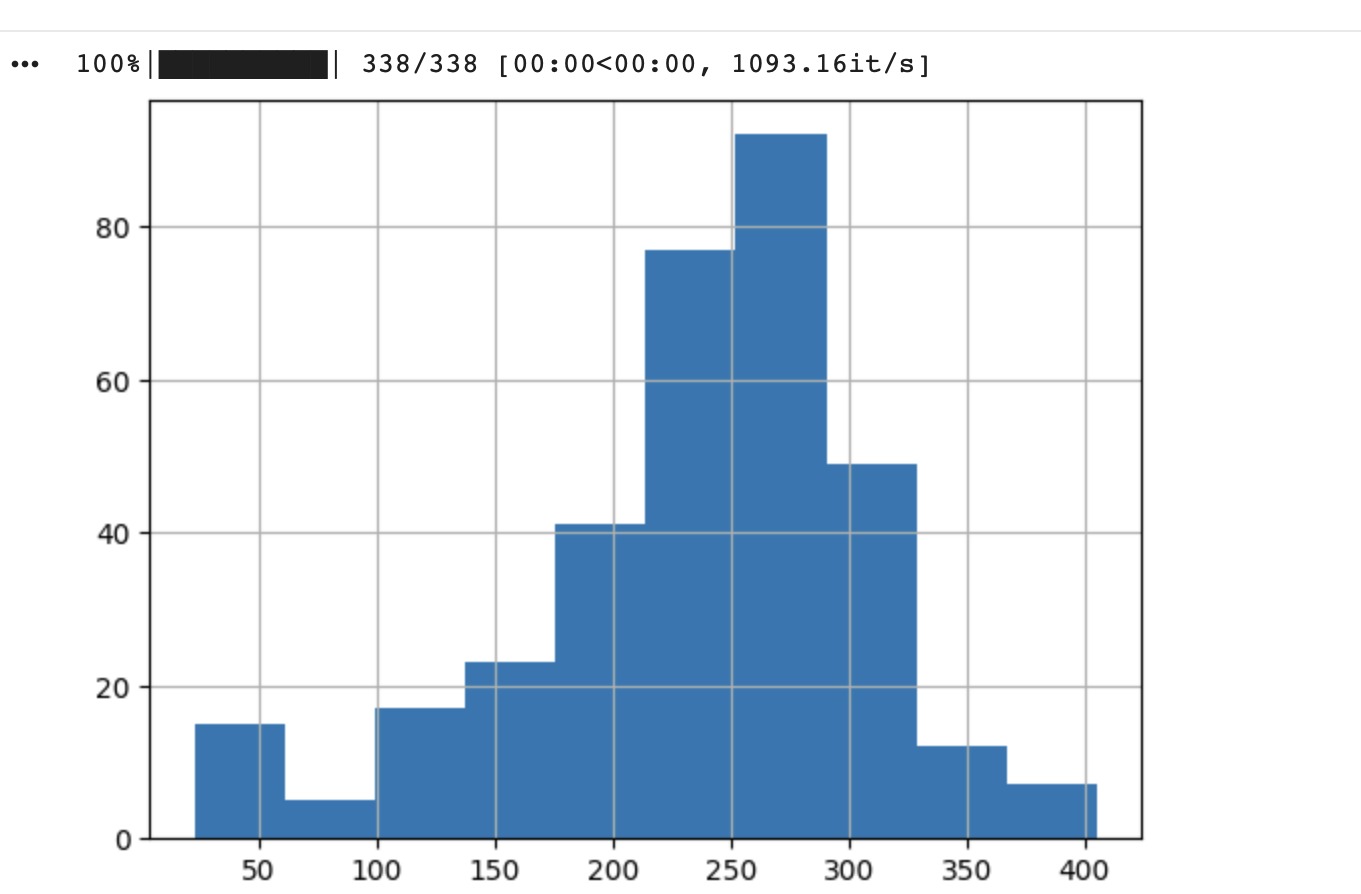

In [ ]:
!pip install -q faiss-cpu

In [ ]:
from langchain_community.vectorstores.faiss import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

EMBEDDING_MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    encode_kwargs={"normalize_embeddings": True},
)

all_docs_for_index = doc_processed + web_chunks

KNOWLAGE_VECTOR_DATABASE = FAISS.from_documents(
    all_docs_for_index,
    embedding_model,
    distance_strategy=DistanceStrategy.COSINE
)

In [ ]:
!pip install -q langchain-openai

In [ ]:
OPENAI_API_KEY=sk-xxxxxxxxxxxxxxxx

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [ ]:
from langchain_openai import ChatOpenAI

reader_llm = ChatOpenAI(
    model_name="gpt-4o",
    temperature=0
)

In [ ]:
def rag_check_plan(q, similarity_threshold=0.8):

    splitter = RecursiveCharacterTextSplitter(

        chunk_size=512,
        chunk_overlap=50,
        separators=["\n\n", "\n", " ", ""]
    )
    chunks = splitter.split_text(q)

    retriever = KNOWLAGE_VECTOR_DATABASE.as_retriever(search_type="mmr", search_kwargs={"k": 3, "fetch_k": 50})
    all_docs = []

    for chunk in chunks:
        print(chunk)
        docs_chunk = retriever.invoke(
            chunk
        )
        all_docs.extend(docs_chunk)

    unique_docs = list({doc.page_content: doc for doc in all_docs}.values())

    if not unique_docs:
        return "Нет достаточных документов для проверки плана лечения."

    context = "\n\n".join([doc.page_content for doc in unique_docs])

    prompt = f"""
Ты — эксперт по медицинской информации.
Задача: проверить план лечения, предоставленный врачом, по документам.

План лечения/история болезни:
{q}

Документы для проверки:
{context}

Инструкции:
- Сравни план с информацией в документах.
- Если есть несоответствия, укажи их и предложи правильный вариант.
- Не придумывай факты, используй только документы.
- Если всё верно, напиши: "План соответствует данным."
"""


    answer = reader_llm.invoke(prompt)
    return answer

In [ ]:
chat_ans = rag_check_plan(q)

In [ ]:
print(chat_ans.content)

In [ ]:
q = """
Диагноз: Рак левой молочной железы сT2N0М0, IIА ст. Трижды негативный подтип. НАПХТ 4АС + 12P и хирургическое лечение в 2017. Прогрессирование от 08.2021 (локальный рецидив + мтс в л\у корня легкого). ПХТ 1 линии (паклитаксел+карбоплатин) с 09.2021 по 03.2022. Прогрессирование от 16.03.2022 (продолженный рост очагов). ХТ 2 линии эрибулином с 03.2022 по 08.2022. Прогрессирование от 03.08.2022. ХТТ 3 линии (карбоплатин+гемцитабин+бевацизумаб) с 19.08.2022 по 02.2023. Прогрессирование от 02.03.2023 (продолженный рост). ХТ 4 линии винорельбином с 22.03.2023 по 05.2023. Прогрессирование от 17.05.2023. ПХТ 5 линии (иксабепилон+капецитабин) с 05.2023 по 12.2023. Прогрессирование от 09.01.2024 . 1 курс ИТ 6 линии атезолизумабом от 02.2024. ХТТ 7 линии (иринотекан+гемцитабин+бевацизумаб ) с 25.03.2024 по 07.2024. Прогрессирование от 08.2024 (продолженный рост). ПХТ 8 линии (паклитаксел+ карбоплатин/цисплатин) с 08.2024 по 03.2025. ХТ 9 линии доксорубицином с 12.2024 по 28.01.2025. Прогрессирование от 10.03.2025 (продолженный рост опухоли в м/ж, л/у, в легких). ХТ 10 линии (циклофосфамид+метотрексат) с 25.05.2025г по 25.07.2025г. ХТТ 11 линии (BCD-236 + винорельбин) с 28.08.2025 по 11.12.2025. Прогрессирование от 16.12.2025 (продолженный рост опухоли в м/ж, л/у, легких).

Анамнез заболевания:

ТАБ опухоли левой молочной железы в 2017г.

ГИ и ИГХ: инфильтративная карцинома G3, ER-0б, PR - 0б, Her 2-1+, Ki67 - 80%.

Комбинированное лечение в 2017 по поводу карциномы левой молочной железы. НАПХТ по схеме: 4 АС + 12P (доксорубицин+циклофосфамид, 1 раз в 3 недели и паклитаксел, еженедельно) и 07.05.2017г выполнена подкожная мастэктомия с установкой импланта.

ГИ Nº 1: инвазивный рак с признаками полного патоморфоза.

Прогрессирование от 08.2021г: рецидив, мтс в подмышечные л/у, л/у корня легкого, яремный л/у?

Биопсия п/о рубца от 16.08.2021.

Гистология и ИГХ №2 от 07.09.2021: инфильтрирующая карцинома молочной железы, неспециального типа G3, тройной негативный фенотип: ER 0 баллов, PR 0 баллов, HER2-статус отрицательный, Кi67 70%

С 09.2021 по 03.2022 - еженедельная ХТ по схеме ТС: Паклитаксел 80 мг/м2 + Карбоплатин AUC2.

МГИ от 05.03.2022: мутации в генах BRCA1/2 не обнаружены.

По данным ПЭТ-КТ от 16.03.2022г - отрицательная динамика.

Протокол врачебного консилиума протокол №1 от 03.2022: рекомендована МХТ по схеме: Эрибулин 1,4 мг/м2 в 1-й, 8-й дни; цикл 21 день - 3 месяца. С 03.2022г по 06.2022г проведено 3 курса.

ПЭТ-КТ от 08.06.2022: по сравнению с ПЭТ-КТ от 16.03.2022 отмечается   увеличение количества патологических очагов в утолщениях кожи сформированной левой м/ж,  увеличение метаболической активности в субпекторальных л/узлах, сохранение метаболической активности в левом надключичном л/у, некоторое снижение метаболической активности в яремных и аксиллярных л/у с обоих сторон, уплотнение паренхимы н/доли правого легкого без динамики -рекомендован КТ-контроль.

МРТ головного мозга от 04.06.2022г. - картина очаговых изменений вещества мозга дисциркулярного характера.

Консилиум от 14.06.2022 г: рекомендовано проведение ХТ по схеме Эрибулин 1,4 мгм2 в 1-й, 8-й дни, цикл 21 день, с последующим контрольным обследованием.

С 06.2022 по 08.2022 проведено 2 курса ПХТ.

ПЭТ-КТ от 03.08.2022г. - отрицательная динамика. Отмечается увеличение метаболической активности в субпекторальных, аксиллярных и надключичных л/у, а также в утолщениях кожи, сформированной ЛМЖ.

12.08.2022г. консилиум, рекомендовано проведение 3 курсов ПХТ по схеме: Карбоплатин AUC4 в 1-й день + Гемцитабин 1000 мг/м2 в 1-й, 8-й дни + Бевацизумаб 7,5 мг/кг 1 раз в 21 день; с последующим контролем.

С 19.08.2022 по 02.2023 проведено 5 курсов ПХТ.

По данным ПЭТ-КТ от 22.11.2022 – положительная динамика. Рекомендовано продолжить ПХТ по прежней схеме.

ПЭТ-КТ от 02.03.2023: в сравнении с ПЭТ-КТ от 22.11.2022г. отмечается отрицательная динамика, обусловленная увеличением объема и активности инфильтрации в области мастэктомии слева с гиперметаболизмом ФДГ-REC ,   увеличением размеров и активности шейного, внутригрудных, аксиллярных и межмышечного л/узлов с гиперметаболизмом ФДГ (мтс),  увеличением размеров очагов в обоих легких без повышенной метаболической активности (мтс).

16.03.2023г выполнена биопсия кожи левой молочной железы.

ГИ № от 21.03.2023: фрагмент кожи с придатками, с ростом в дерме низкодифференцированной карциномы солидного типа строения с очагами некроза, с прорастанием в подкожно-жировую клетчатку, с вовлечением потовых желез, с признаками васкулярной и периневральной инвазии (LV1 Pn1). Латеральный край резекции позитивный, TILs 10%.

ИГХ № от 31.03.2023: ER 0 баллов, PR 0 баллов, HER2-статус отрицательный (0), Кi67 40%

Протокол консилиума Nº 6437 от 15.03.2023: рекомендована МХТ по схеме: Винорельбин 25 мг/м2 в 1-й и 8-й дни, каждые 3 недели.

С 22.03.2023 по 05.2023 - проведено 3 курса МХТ винорельбином.

ПЭТ-КТ от 17.05.2023: в сравнение с исследованием от 02.03.2023 отрицательная динамика, которая обусловлена  увеличением инфильтративных изменений кожи импланта левой м/ж вторичного генеза; увеличением количества и размеров очаговых образований паренхимы легких и л/у шеи, средостения и аксиллярных областей с метаболической активностью ФДГ,  очаговой активности РФП паренхимы селезенки вторичного генеза.

ИГХ № от 24.04.2023: протоковый рак м/ж, PD-L1 CPS 10.

Протокол Nº  от 29.05.2023: рекомендована ПХТ по схеме: Иксабепилон 40 мг/м2 в/в в 1-й день + капецитабин 2000 мг/м2 внутрь в 1-14-й дни; цикл 21 день.

С 05.23г проведено 3 курса ПХТ. Положительная динамика по ПЭТ-КТ.

МГИ от 17.09.2023: pMMR, MSS.

Удаление имланта левой м/ж от 18.09.2023г.

Проведено еще 2 курса ПХТ, до 12.2023.

ПЭТ-КТ от 09.01.2024: в сравнение с исследованием от 23.08.2023 отрицательная динамика, обусловленная  увеличением в размерах образований кожи левой м/ж,  увеличением аксиллярных л/узлов с обеих сторон с метаболической активностью ФДГ. Сохраняется наличие очаговых образований паренхимы легких, л/узлов шеи и средостения с избирательной метаболической активностью ФДГ.

Онкоконсилиум рекомендовано: лекарственная терапия Атезолизумаб 1200 мг в 1-й день; цикл 21 день. Проведено 1 введение от 02.2024г. На фоне проводимого лечения, появилась слабость, быстрая утомляемость, температура тела до 39 (в течение недели), рвота.

МГИ от 01.03.2024: MSS, TMB 6.42 (низкий уровень).

Онкологический консилиум МКНЦ Логинова: рекомендовано лечение по схеме: иринотекан 125 мг/м2 1,15 дни + гемцитабин 750 мг/м2 1,15 дни + бевацизумаб 10 мг/кг 1 раз в 3 недели.

С 25.03.2024г. - проведен 1 курс ПХТ.

ПЭТ-КТ от 28.03.2024: - в сравнении с исследованием от 23.08.2023 отрицательная динамика: увеличение в размерах образований кожи левой м/ж с метаболической активностью ФДГ.

По данным ПЭТ-КТ от 29.05.2024 в сравнении с исследованием от 28.03.2024 динамика положительная.

Продолжено лечение по прежней схеме до 07.2024г.

Прогрессирование от августа 2024: рост опухоли в м/ж.

С 08.24г по 11.2024 химиотерапия: Паклитаксел 80 мг/м2 еженедельно + Карбоплатин AUC2 (аллергическая реакция) + Цисплатин 1 раз в 28 дней.

C 12.2024 по 28.01.2025: доксорубицин в еженедельном режиме. Отмена в связи с инфицированием порт-системы.

ПЭТ-КТ от 10.03.2025: отрицательная динамика при сравнении с ПЭТ-КТ от 18.11.2024. Получены данные о наличии активной опухолевой ткани в надклочичных л/узлах слева, в мягких тканях протезированной левой м/ж, в легких, во внутригрудных л/узлах, в подмышечных л/узлах с обеих сторон.

19.03.2025г выполнена операция: удаление подкожной венозной порт системы.

Проведено  3 онкоконсилиума – рекомендована МХТ этопозидом  или ПХТ циклофосфамид + метотрексат. В виду дефектуры препаратов терапию не получала.

С 28.04.25г пациентка проходила скрининг в исследовании

Исследование опухолевого материала, полученного в результате биопсии рецидива опухоли в п/о рубце от 16.08.2021 и биопсии имплантационного мтс в кожу левой молочной железы от 03.2023г:

Получен результат исследования экспрессии AXL:

1. Морфологическая картина и иммунофенотип опухоли соответствуют рецидиву рака молочной железы. AXL: позитивная реакция (+) в 1 % опухолевых клеток, позитивная реакция в 10% иммунных клеток относительно площади опухоли.

2. Морфологическая картина и иммунофенотип опухоли соответствуют метастазу рака молочной железы. AXL: позитивная реакция (++) в 3 % опухолевых клеток, позитивная реакция в 15 % иммунных клеток относительно площади опухоли.

16.05.25г пациентка досрочно завершила участие в исследовании ввиду наличия критерия невключения №2: впервые выявленные в ходе скрининга метастазы в ЦНС.

С 03.06.2025г по 05.06.2025г проведен курс стереотаксической лучевой терапии с облучением метастазов левой лобной и правой затылочной области со средней дозой 8 Гр 3 фракции до СОД24 Гр. 06.06.2025г проведен курс стереотаксической лучевой терапии с облучением метастазов левой лобной (парасаггитально) и левой затылочной области со средней дозой 18Гр за 1 фракцию.

С 25.05.2025г по 25.07.2025г – химиотерапия в метрономном режиме: циклофосфамид 50 мг внутрь ежедневно + метотрексат по 2,5 мг внутрь 2 раза в день в 1й и 2й дни каждой недели.

ПЭТ/КТ от 12.08.25г: в сравнении с ПЭТ-КТ от 10.03.2025г отрицательная динамика, обусловлена:

-увеличением количества, размеров узловых образований левой молочной железы, с гиперметаболической активностью;

-увеличением количества, избирательным увеличением размеров, уровня метаболической активности внутригрудных л\узлов;

-ростом размеров образований в легких, с повышением уровня метаболической активности;

- ростом размеров подмышечных л\у с обеих сторон, единичных надключичных лимфоузлов слева, с повышением уровня гиперметаболизма ФДГ;

- наличием подключичных л\у справа, ретрокрурального л\у справа с повышенной метаболической активностью.

МРТ ГМ от 14.08.25г: МР картина очаговых образований в веществе головного мозга, вероятно неопластического характера, с уменьшением размеров и перифокальных изменений при сравнении с МРТ исследованием от 26.05.2025г.

КТ ОГК, ОБП, ОМТ с контрастом от 22.08.2025: Образования мозга вторичного характера. Множественные образования левой молочной железы с инвазией в мышцы грудной стенки. Вторичное поражение аксиллярных, интерпекторальных, медиастинальных лимфоузлов, легких. Отрицательная динамика. Дивертикул 12перстной кишки. Дивертикулы сигмовидной кишки.

С 28.08.2025 по 11.12.2025 в рамках клинического исследования получала: 20 мг/кг в 1-й день + винорельбин 25 мг/м2 в 1-й и 8-й дни каждого 21-дневного цикла.

КТ ОГК, ОБП, ОМТ с контрастом от 10.2025: Образования мозга вторичного характера без динамики. Множественные образования левой молочной железы с инвазией в мышцы грудной стенки. Вторичное поражение аксиллярных, интерпекторальных, медиастинальных лимфоузлов, легких. Положительная динамика. Дивертикул 12перстной кишки. Дивертикулы сигмовидной кишки.

КТ ОГК, ОБП, ОМТ с контрастом от 16.12.2025 и 17.12.2025: Множественные образования левой молочной железы с инвазией в мышцы грудной стенки. Вторражение аксиллярных, интерпекторальных, медиастинальных лимфоузлов, легких. Отрицательная динамика. Дивертикул 12перстной кишки. Дивертикулы сигмовидной кишки. Образования мозга вторичного характера без динамики.